# Hair Removal

(Text(0.5, 1.0, 'Inpainted Image'), ([], []), ([], []))

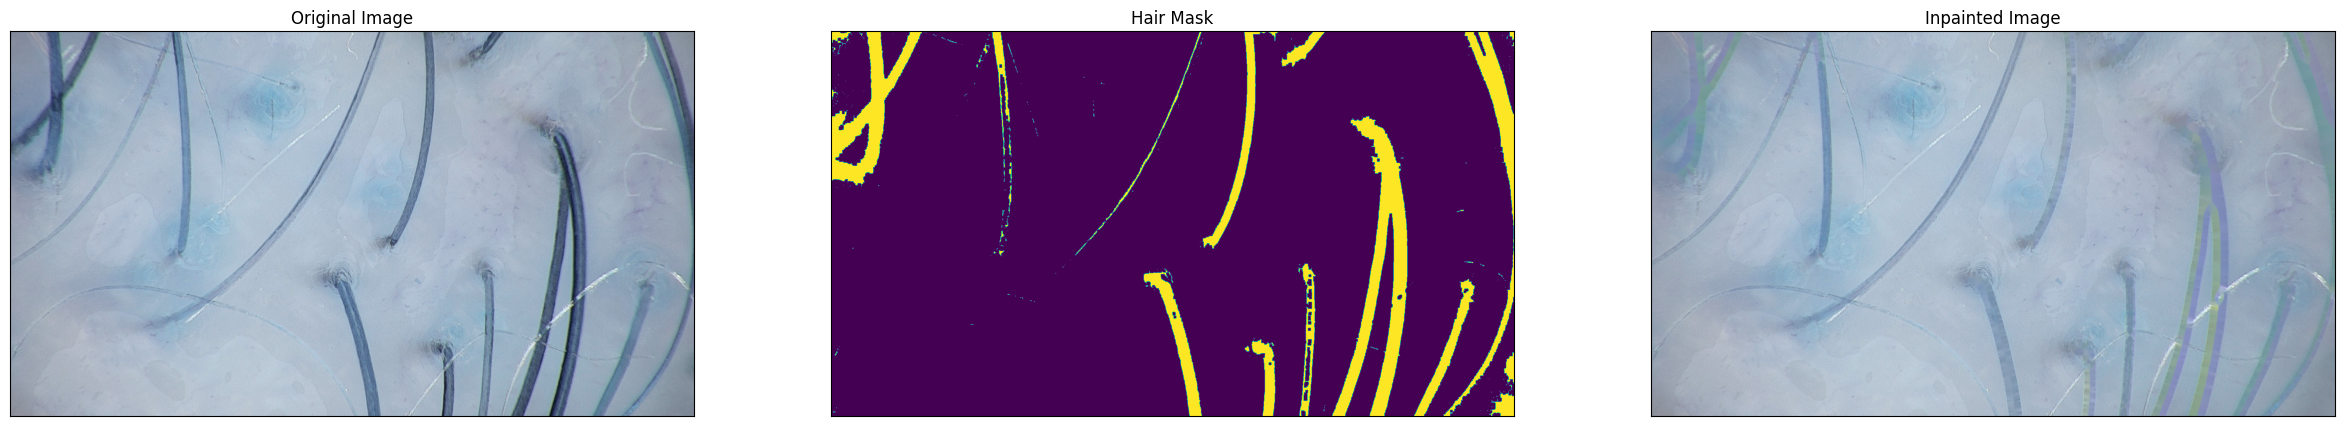

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = './łysienie/03945.jpg'
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply a threshold to detect hair (adjust threshold value as needed)
_, hair_mask = cv2.threshold(gray, 140, 160, cv2.THRESH_BINARY_INV)

# Apply morphological operations to enhance the hair mask
kernel = np.ones((3, 3), np.uint8)
hair_mask = cv2.morphologyEx(hair_mask, cv2.MORPH_CLOSE, kernel, iterations=3)

# Inpaint the hair regions
telea = cv2.inpaint(image, hair_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

plt.figure(figsize=(30,10))
plt.subplot(131),plt.imshow(image)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(hair_mask)
plt.title('Hair Mask'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(telea)
plt.title('Inpainted Image'), plt.xticks([]), plt.yticks([])

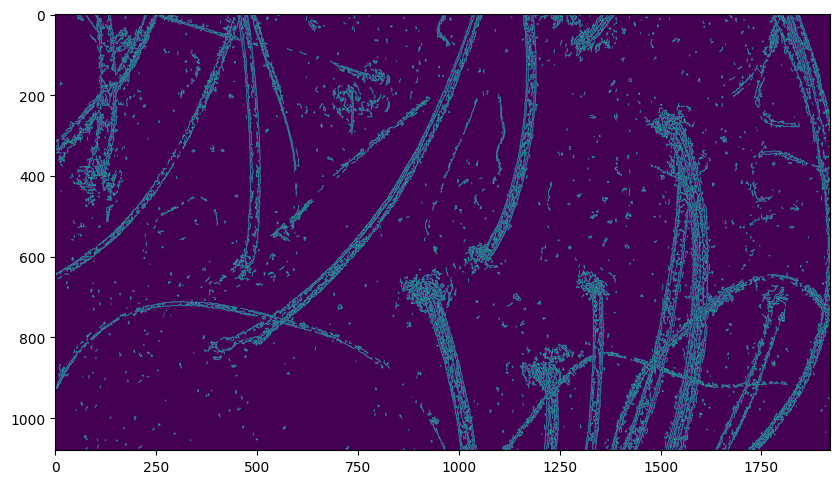

In [42]:
image_path = './łysienie/03945.jpg'
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

canny = cv2.Canny(image, 40, 80)

plt.figure(figsize=(10,8))
plt.imshow(canny)

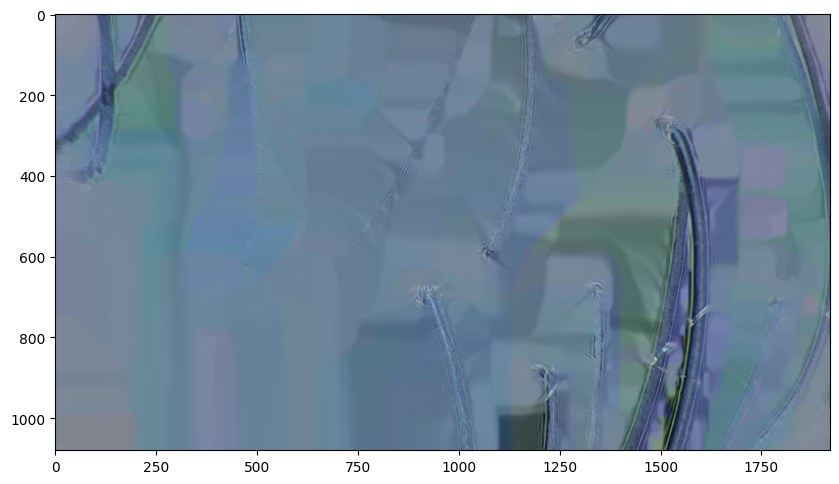

In [7]:
inverted_mask = cv2.bitwise_not(hair_mask)
telea = cv2.inpaint(image, inverted_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
# result = cv2.xphoto.inpaint(image, hair_mask, inpaintRadius=7, method=cv2.xphoto.INPAINT_SHIFTMAP)

dst = image.copy()
cv2.xphoto.inpaint(image, hair_mask, dst, cv2.xphoto.INPAINT_FSR_FAST)
plt.figure(figsize=(10,8))
plt.imshow(dst)

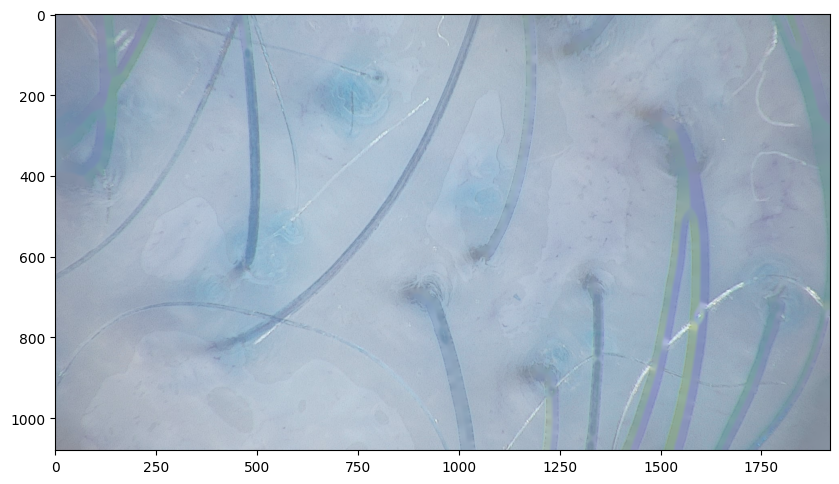

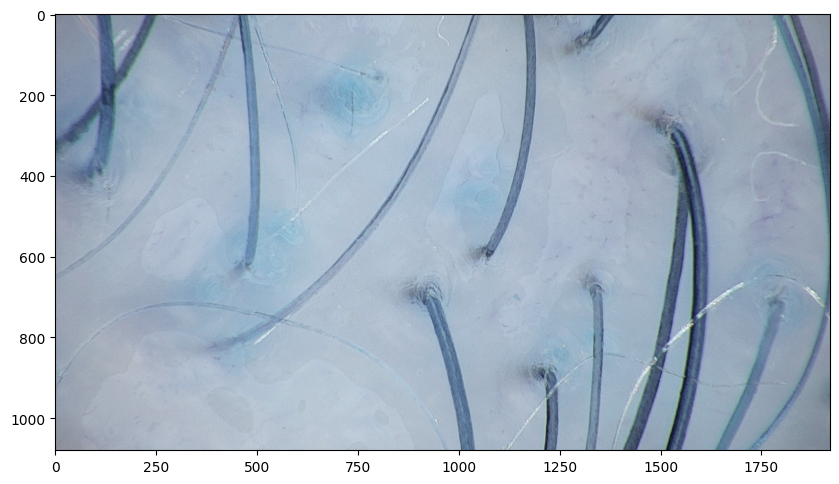

In [24]:
# Split channels
# b, g, r = cv2.split(image)
# b_inp = cv2.inpaint(b, hair_mask, 3, cv2.INPAINT_TELEA)
# g_inp = cv2.inpaint(g, hair_mask, 3, cv2.INPAINT_TELEA)
# r_inp = cv2.inpaint(r, hair_mask, 3, cv2.INPAINT_TELEA)

inpainted = cv2.inpaint(image, hair_mask, 8, cv2.INPAINT_TELEA)

# Merge back
# final = cv2.merge([b_inp, g_inp, r_inp])
plt.figure(figsize=(10,8))
plt.imshow(inpainted)
plt.figure(figsize=(10,8))
plt.imshow(image)

In [9]:
import cv2
import numpy as np
from skimage.restoration import inpaint_biharmonic
from skimage.transform import resize
from skimage import img_as_ubyte

def smart_biharmonic_inpaint(image: np.ndarray, mask: np.ndarray, scale_factor=0.5) -> np.ndarray:
    """
    Perform robust biharmonic inpainting on a large image via downscaling and upscaling.

    Args:
        image (np.ndarray): Input BGR image
        mask (np.ndarray): Binary mask (same size, dtype=np.uint8)
        scale_factor (float): Downscale factor to reduce memory (0.5 = 50%)

    Returns:
        np.ndarray: Inpainted BGR image (uint8)
    """
    # Convert BGR to RGB and normalize
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
    mask_bool = mask > 0

    # Downscale for fast marching method
    new_shape = (int(image.shape[0] * scale_factor), int(image.shape[1] * scale_factor))
    img_small = resize(image_rgb, new_shape, preserve_range=True)
    mask_small = resize(mask_bool.astype(float), new_shape, order=0, preserve_range=True) > 0

    # Inpaint each channel
    inpainted_small = np.zeros_like(img_small)
    for i in range(3):
        inpainted_small[..., i] = inpaint_biharmonic(img_small[..., i], mask_small, channel_axis=None)

    # Upscale back to original size
    inpainted_large = resize(inpainted_small, image_rgb.shape, preserve_range=True)
    inpainted_rgb_uint8 = img_as_ubyte(np.clip(inpainted_large, 0, 1))

    # Convert back to BGR for OpenCV consistency
    return cv2.cvtColor(inpainted_rgb_uint8, cv2.COLOR_RGB2BGR)




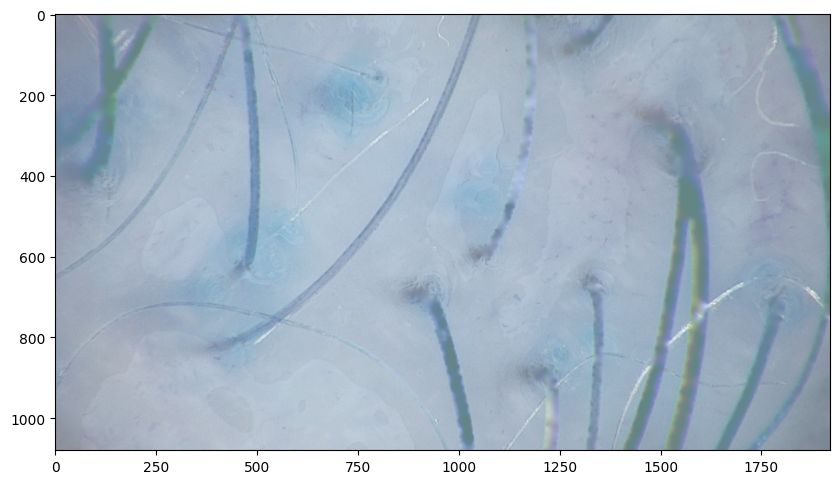

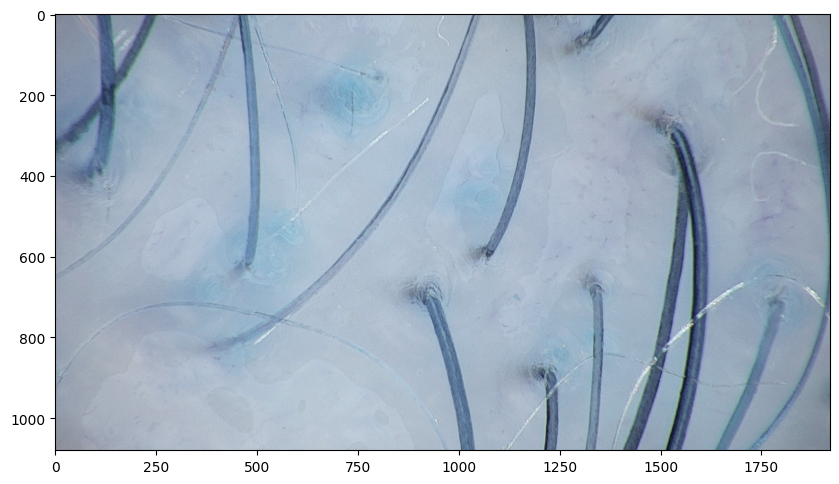

In [14]:
result = smart_biharmonic_inpaint(image, hair_mask, scale_factor=0.6)

plt.figure(figsize=(10,8))
plt.imshow(result)
plt.figure(figsize=(10,8))
plt.imshow(image)

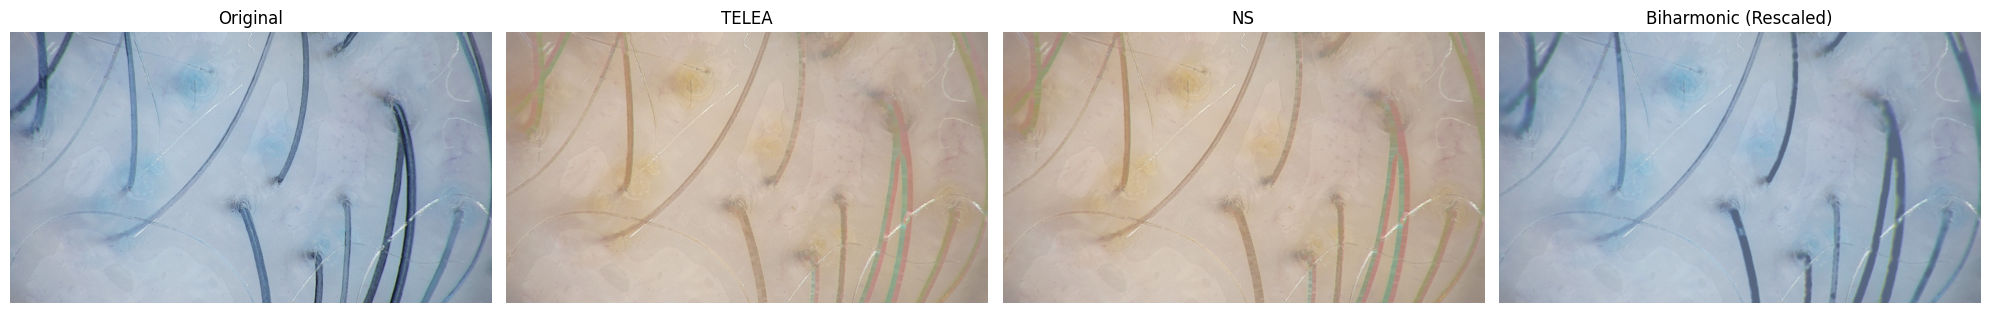

In [28]:
# Re-run inpainting comparisons using TELEA, NS, and Biharmonic only (no xphoto)
from skimage.restoration import inpaint_biharmonic
# Inpainting Method 1: TELEA
telea = cv2.inpaint(image, hair_mask, 3, cv2.INPAINT_TELEA)

# Inpainting Method 2: Navier-Stokes
ns = cv2.inpaint(image, hair_mask, 3, cv2.INPAINT_NS)

# Inpainting Method 3: Biharmonic via skimage (on downscaled image)
image_small = resize(image / 255.0, (image.shape[0] // 2, image.shape[1] // 2), preserve_range=True)
mask_small = resize(hair_mask > 0, (image.shape[0] // 2, image.shape[1] // 2), order=0, preserve_range=True) > 0

inpainted_small = np.zeros_like(image_small)
for i in range(3):
    inpainted_small[..., i] = inpaint_biharmonic(image_small[..., i], mask_small, channel_axis=None)

# Upscale to original size
inpainted_large = resize(inpainted_small, image.shape, preserve_range=True)
inpainted_large_uint8 = img_as_ubyte(np.clip(inpainted_large, 0, 1))

# Display the results
titles = ["Original", "TELEA", "NS", "Biharmonic (Rescaled)"]
images = [
    image,
    cv2.cvtColor(telea, cv2.COLOR_BGR2RGB),
    cv2.cvtColor(ns, cv2.COLOR_BGR2RGB),
    inpainted_large_uint8
]

fig, axs = plt.subplots(1, 4, figsize=(20, 8))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(images[i])
    ax.set_title(titles[i])
    ax.axis("off")

plt.tight_layout()
plt.show()


# Hair blackening

39
48
50
122
53
51
52
91
40
52
85
55
52
129
87
111
50
44
114
152
36
59
109
86
303
91
174
129
113
77
86
47
31
116
141
314
35
261
136
84
186
99
338
72
129
226
194
101
39
80
50
107
100
234
226
166
46
81
48
45
157
50
179
149
142
122
93
61
59
130
47
126
38
75
103
215
135
121
291
180
616
186
46
425
121
37
247
63
578
52
170
131
266
188
217
56
102
43
123
29
52
54
56
220
63
44
66
45
622
192
60
295
46
132
68
53
44
493
131
148
575
225
270
157
358
57
332
190
256
151
68
27
56
39
80
343
21
308
290
704
765
545
233
100
42
285
52
1314
90
434
80
163
89
92
39
672
315
52
164
48
125
274
222
156
215
80
104
136
641
29
153
182
179
97
228
79
59
49
86
560
117
115
107
130
95
97
53
190
71
13
486
86
698
287
720
112
738
211
129
38
92
116
72
74
1035
198
311
202
57
57
707
624
89
31
60
44
57
675
132
456
164
307
42
68
452
195
119
63
648
90
33
45
202
910
125
44
68
56
92
132
56
100
56
180
84
56
127
131
83
46
999
89
68
450
260
340
738
1838
109
175
114
60
126
93
236
227
76
64
98
1331
404
130
183
93
248
59
50
205
408
439
37

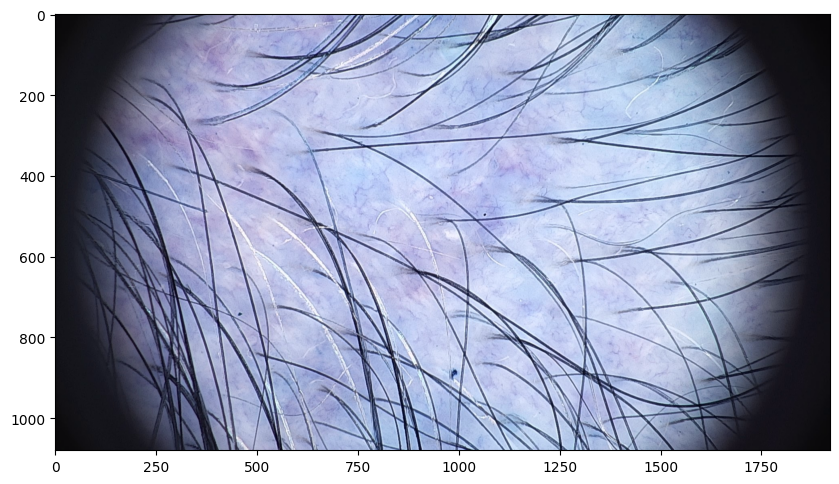

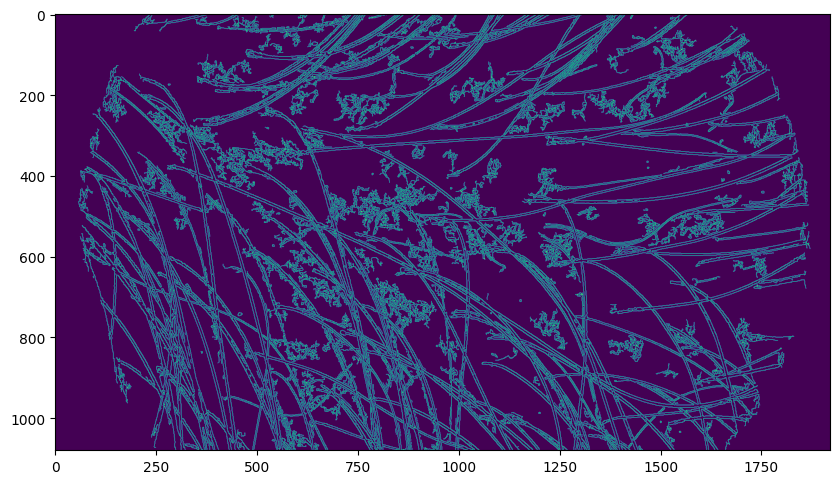

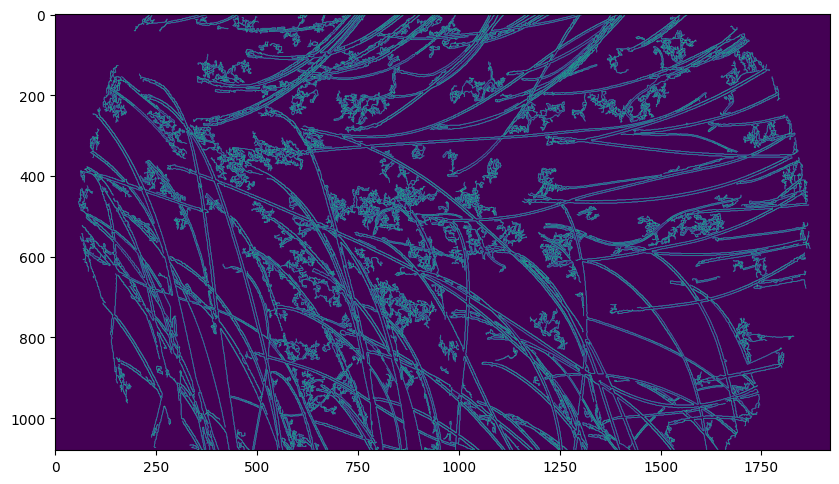

In [51]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

# Load the image
image_path = "łysienie/02167.jpg"
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply edge detection to highlight hair strands
edges = cv2.Canny(gray, 50, 100)

edges2 = cv2.Canny(image, 125, 1750, apertureSize=5, L2gradient=True)


# blurred = cv2.bilateralFilter(edges2, 9, 75, 75)
# edges_balanced = cv2.Canny(blurred, 50, 150)
contours, _ = cv2.findContours(edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
filtered = np.zeros_like(edges)
for cnt in contours:
    area = cv2.contourArea(cnt)
    length = cv2.arcLength(cnt, closed=True)
    perimeter = cv2.arcLength(cnt, True)

    if perimeter == 0:
        continue

    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h if h != 0 else 0

    if length < 80:  # skip small curves/dots
        continue

    # if area == 0:
    #     continue

    circularity = 4 * np.pi * area / (length ** 2)
    
    # A perfect circle has circularity = 1. Lower means more linear.
    # if circularity > 0.8:  # tune this threshold
    #     continue
    print(len(cnt))
    if 0.3 < aspect_ratio < 10:
        cv2.drawContours(filtered, [cnt], -1, 255, thickness=1)

# contour_image = np.zeros_like(gray)
# cv2.drawContours(contour_image, contours, -1, 255, 1)

edges3 = cv2.Canny(gray, 250, 150)

# Dilate the edges to make them more visible and connected
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
dilated_edges = cv2.dilate(edges, kernel, iterations=1)

# Create a mask from the dilated edges
mask = dilated_edges > 0

# Create a black image
black_image = np.zeros_like(image)

# Apply the mask to make detected hairs black on the original image
image_with_black_hairs = image.copy()
image_with_black_hairs[mask] = black_image[mask]

# Convert the image with mask to RGB for displaying
image_with_black_hairs_rgb = cv2.cvtColor(image_with_black_hairs, cv2.COLOR_BGR2RGB)

# Save the result images for display
# result_mask_path = "/mnt/data/hair_mask.png"
# result_image_path = "/mnt/data/image_with_black_hairs.png"
# cv2.imwrite(result_mask_path, dilated_edges)
# cv2.imwrite(result_image_path, cv2.cvtColor(image_with_black_hairs_rgb, cv2.COLOR_RGB2BGR))

plt.figure(figsize=(10,8))
plt.imshow(image)

plt.figure(figsize=(10,8))
plt.imshow(edges2)

plt.figure(figsize=(10,8))
plt.imshow(filtered)